In [1]:
print("Setting UP")
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import os, random
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from pathlib import Path
import tensorflow as tf
from PIL import Image 


Setting UP


In [2]:
savedModel=load_model('gfModel.h5')
savedModel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 60)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                  

In [3]:
test_X = pickle.load(open('xtest', 'rb')) 

In [4]:
test_y = pickle.load(open('ytest', 'rb')) 

In [5]:
score = savedModel.evaluate(test_X, test_y, verbose=0)
print('Test Score = ',score[0])
print('Test Accuracy =', score[1])

Test Score =  0.019078535959124565
Test Accuracy = 0.9955511689186096


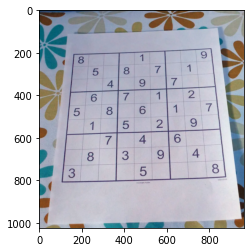

In [6]:
sudoku = cv2.imread(r"C:\Users\ASUS\Desktop\sudokuimages\opencv_sudoku_puzzle_sudoku_puzzle.webp")
plt.figure()
plt.imshow(sudoku)
plt.show() 

In [7]:
imgheight=450
imgwidth=450
sudoku=cv2.resize(sudoku,(imgheight,imgwidth))
imgBlank=np.zeros((imgheight,imgwidth,3),np.uint8) #create balnk image for debugging purpose

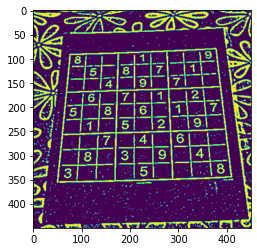

In [8]:
# function to greyscale, blur and change the receptive threshold of image
def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    blur = cv2.GaussianBlur(gray, (3,3),6) 
    threshold = cv2.adaptiveThreshold(blur,255,1,1,11,2)
    return threshold

threshold = preprocess(sudoku)

plt.figure()
plt.imshow(threshold)
plt.show()

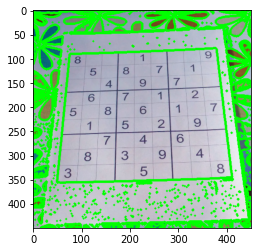

In [9]:
# Outline the sudoku puzzle
con1 = sudoku.copy()
con2 = sudoku.copy()
contour, hier = cv2.findContours(threshold,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(con1, contour,-1,(0,255,0),3)

#let's see what we got
plt.figure()
plt.imshow(con1)
plt.show()

In [10]:
def main_outline(contour):
    big = np.array([])
    max_area = 0
    for i in contour:
        area = cv2.contourArea(i)
        if area >50:
            peri = cv2.arcLength(i, True)
            apx = cv2.approxPolyDP(i , 0.02* peri, True)
            if area > max_area and len(apx) ==4:
                big = apx
                max_area = area
    return big ,max_area

In [11]:
# reorder the  frame corners so each time it remains the same
def reorder(points):
    points = points.reshape((4, 2))
    new_points = np.zeros((4,1,2),dtype = np.int32)
    add = points.sum(1)
    new_points[0] = points[np.argmin(add)]
    new_points[3] = points[np.argmax(add)]
    diff = np.diff(points, axis =1)
    new_points[1] = points[np.argmin(diff)]
    new_points[2] = points[np.argmax(diff)]
    return new_points

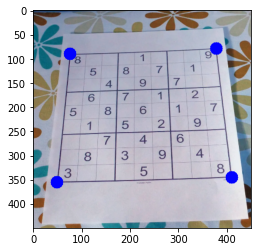

In [12]:
# Identified the Corners
black_img = np.zeros((imgheight,imgwidth,3), np.uint8)
big, maxArea = main_outline(contour)
if big.size != 0:
    big = reorder(big)
    cv2.drawContours(con2,big,-1, (0,0,255),25)
    pts1 = np.float32(big)
    pts2 = np.float32([[0,0],[imgheight,0],[0,imgwidth],[imgheight,imgwidth]])
    matrix = cv2.getPerspectiveTransform(pts1,pts2)  
    imagewrap = cv2.warpPerspective(sudoku,matrix,(imgheight,imgwidth))
    imgDetectedDigits=imgBlank.copy()
    imagewrap =cv2.cvtColor(imagewrap, cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(con2)
plt.show()

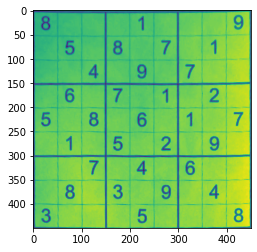

In [13]:
plt.figure()
plt.imshow(imagewrap)
plt.show()

In [14]:
# Identifying each induvidual cells
def splitcells(img):
    rows = np.vsplit(img,9)
    box = []
    for r in rows:
        cols = np.hsplit(r,9)
        for b in cols:
            box.append(b)
    return box

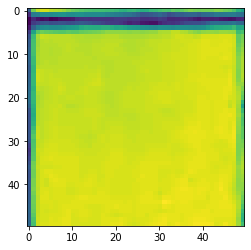

In [15]:
sudoku_cell = splitcells(imagewrap)
#Let's have alook at the last cell
plt.figure()
plt.imshow(sudoku_cell[33])
plt.show()

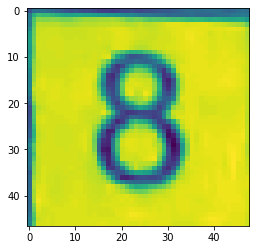

In [16]:
# cropping the boundaries

def CropCell(cells):
    Cells_croped = []
    for i in cells:
        
        img = np.array(i)
        img = img[3:50, 2:50]
        img = Image.fromarray(img)
        Cells_croped.append(img)
        
    return Cells_croped

Sudoku_cropped_cells= CropCell(sudoku_cell)

plt.figure()
plt.imshow(Sudoku_cropped_cells[0])
plt.show()

In [17]:
def read_cells(cell,model):
    res = []
    for i in cell:
        # preprocess the image as in  the model 
        img = np.asarray(i)
        img = img[4:img.shape[0] - 4, 4:img.shape[1] -4]
        img = cv2.resize(img, (32, 32))
        img = img / 255
        img = img.reshape(1, 32, 32, 1)
        
        # getting predictions and setting the values if probabilities are above 65% 
        
        predictions = model.predict(img)
        classIndex = np.argmax(predictions,axis=-1)
        probValue = np.amax(predictions)
        print(classIndex,probValue)
        
        if probValue > 0.65:
            res.append(classIndex[0])
        else:
            res.append(0)
    return res

grid = read_cells(Sudoku_cropped_cells, savedModel)
grid = np.asarray(grid)

1/1 [==============================] - 0s 70ms/step
[8] 0.97688633
1/1 [==============================] - 0s 4ms/step
[1] 0.19996868
1/1 [==============================] - 0s 7ms/step
[1] 0.20123449
1/1 [==============================] - 0s 20ms/step
[1] 0.20106153
1/1 [==============================] - 0s 14ms/step
[1] 0.9440696
1/1 [==============================] - 0s 14ms/step
[1] 0.20106153
1/1 [==============================] - 0s 21ms/step
[1] 0.20106153
1/1 [==============================] - 0s 14ms/step
[1] 0.20106153
1/1 [==============================] - 0s 24ms/step
[9] 0.9952301
1/1 [==============================] - 0s 14ms/step
[1] 0.20196897
1/1 [==============================] - 0s 14ms/step
[5] 0.99639314
1/1 [==============================] - 0s 14ms/step
[1] 0.20104721
1/1 [==============================] - 0s 18ms/step
[8] 0.97678727
1/1 [==============================] - 0s 14ms/step
[1] 0.20106153
1/1 [==============================] - 0s 21ms/step
[7] 0.9466677


In [18]:
def splitBoxes(img):
    rows=np.vsplit(img,9)
    boxes=[]
    for i in rows:
        cols=np.hsplit(i,9)
        for box in cols:
            boxes.append(box)
    return boxes

In [19]:
## split image cells
imgSolvedDigits=imgBlank.copy()
boxes=splitBoxes(imagewrap)
print(len(boxes))
numbers=read_cells(boxes,savedModel)
print(numbers)

81
1/1 [==============================] - 0s 21ms/step
[8] 0.958316
1/1 [==============================] - 0s 21ms/step
[7] 0.1946784
1/1 [==============================] - 0s 20ms/step
[7] 0.26664487
1/1 [==============================] - 0s 14ms/step
[7] 0.26200482
1/1 [==============================] - 0s 14ms/step
[1] 0.8581872
1/1 [==============================] - 0s 22ms/step
[1] 0.16294096
1/1 [==============================] - 0s 20ms/step
[1] 0.19474667
1/1 [==============================] - 0s 18ms/step
[1] 0.20106153
1/1 [==============================] - 0s 7ms/step
[9] 0.98771685
1/1 [==============================] - 0s 17ms/step
[1] 0.20115894
1/1 [==============================] - 0s 13ms/step
[5] 0.9772948
1/1 [==============================] - 0s 16ms/step
[1] 0.19995154
1/1 [==============================] - 0s 10ms/step
[8] 0.9685185
1/1 [==============================] - 0s 7ms/step
[1] 0.20139687
1/1 [==============================] - 0s 16ms/step
[7] 0.8996104
1

In [20]:
def displayNumbers(img, numbers, color=(0, 255, 0)):
    W = int(img.shape[1]/9)
    H = int(img.shape[0]/9)
    for i in range (9):
        for j in range (9):
            if numbers[(j*9)+i] != 0:
                cv2.putText(img, str(numbers[(j*9)+i]),
                            (i*W+int(W/2)-10,int((j+0.8)*H)),
                            cv2.FONT_HERSHEY_COMPLEX, 2,
                            color,2, cv2.LINE_AA)
    return img

In [21]:
imgDetectedDigits = displayNumbers(imgDetectedDigits,numbers,color=(255,0,255))

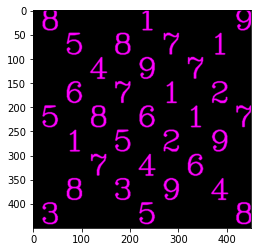

In [22]:
plt.figure()
plt.imshow(imgDetectedDigits)
plt.show()

In [23]:
numbers=np.array(numbers)
posarray=np.where(numbers > 0,0,1)
print(posarray)

[0 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1
 1 1 0 1 1 1 0]


### Solution of the board

In [24]:
# Solves a sudoku board using backtracking
def solve(bo):
    """

    :param bo: 2d list of ints
    :return: solution
    """
    find = find_empty(bo)
    if find:
        row, col = find
    else:
        return True
    for i in range(1,10):
        if valid(bo, (row, col), i):
            bo[row][col] = i

            if solve(bo):
                return True

            bo[row][col] = 0

    return False

In [25]:
# Returns if the attempted move is valid
def valid(bo, pos, num):
    """

    :param bo: 2d list of ints
    :param pos: (row, col)
    :param num: int
    :return: bool
    """

    # Check row
    for i in range(0, len(bo)):
        if bo[pos[0]][i] == num and pos[1] != i:
            return False

    # Check Col
    for i in range(0, len(bo)):
        if bo[i][pos[1]] == num and pos[1] != i:
            return False

    # Check box

    box_x = pos[1]//3
    box_y = pos[0]//3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x*3, box_x*3 + 3):
            if bo[i][j] == num and (i,j) != pos:
                return False

    return True

In [26]:
# Finds the empty spaces
def find_empty(bo):
    """

    :param bo: partially complete board
    :return: (int, int) row col
    """

    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i, j)

    return None

In [27]:
# prints the board
def print_board(bo):
    """

    :param bo: 2d List of ints
    :return: None
    """
    for i in range(len(bo)):
        if i % 3 == 0 and i != 0:
            print("- - - - - - - - - - - - - -")
        for j in range(len(bo[0])):
            if j % 3 == 0:
                print(" | ",end="")

            if j == 8:
                print(bo[i][j], end="\n")
            else:
                print(str(bo[i][j]) + " ", end="")

In [28]:
Sudoku_board = np.array_split(numbers,9)
print(Sudoku_board)

try:
    solve(Sudoku_board)

except:
    pass
print(Sudoku_board)

[array([8, 0, 0, 0, 1, 0, 0, 0, 9], dtype=int64), array([0, 5, 0, 8, 0, 7, 0, 1, 0], dtype=int64), array([0, 0, 4, 0, 9, 0, 7, 0, 0], dtype=int64), array([0, 6, 0, 7, 0, 1, 0, 2, 0], dtype=int64), array([5, 0, 8, 0, 6, 0, 1, 0, 7], dtype=int64), array([0, 1, 0, 5, 0, 2, 0, 9, 0], dtype=int64), array([0, 0, 7, 0, 4, 0, 6, 0, 0], dtype=int64), array([0, 8, 0, 3, 0, 9, 0, 4, 0], dtype=int64), array([3, 0, 0, 0, 5, 0, 0, 0, 8], dtype=int64)]
[array([8, 7, 2, 4, 1, 3, 5, 6, 9], dtype=int64), array([9, 5, 6, 8, 2, 7, 3, 1, 4], dtype=int64), array([1, 3, 4, 6, 9, 5, 7, 8, 2], dtype=int64), array([4, 6, 9, 7, 3, 1, 8, 2, 5], dtype=int64), array([5, 2, 8, 9, 6, 4, 1, 3, 7], dtype=int64), array([7, 1, 3, 5, 8, 2, 4, 9, 6], dtype=int64), array([2, 9, 7, 1, 4, 8, 6, 5, 3], dtype=int64), array([6, 8, 5, 3, 7, 9, 2, 4, 1], dtype=int64), array([3, 4, 1, 2, 5, 6, 9, 7, 8], dtype=int64)]


In [29]:
flatlist = []
for sublist in Sudoku_board:
    for item in sublist:
        flatlist.append(item)
solvedNumbers=flatlist*posarray
imgSolvedDigits=displayNumbers(imgSolvedDigits,solvedNumbers)


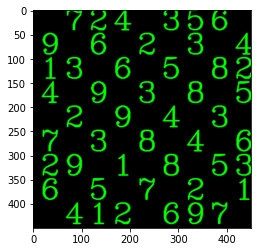

In [30]:
# Solution only maxtrix
plt.figure()
plt.imshow(imgSolvedDigits)
plt.show()

In [31]:
# Overlay the Solution
pts1 = np.float32([[0, 0], [imgwidth, 0], [0, imgheight], [imgwidth, imgheight]])
pts2 = np.float32(big)
# Apply Perspective Transform Algorithm

matrix = cv2.getPerspectiveTransform(pts1, pts2)
imgInvWarpColored = cv2.warpPerspective(imgSolvedDigits, matrix,(imgwidth, imgheight))


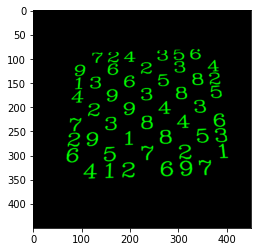

In [32]:
plt.figure()
plt.imshow(imgInvWarpColored)
plt.show()

In [38]:
inv_perspective=cv2.addWeighted(imgInvWarpColored, 1,sudoku,0.5,1)
combined = cv2.addWeighted(imgInvWarpColored, 1,sudoku,0.5,1)
cv2.imshow("Final result", combined)
cv2.waitKey(0)

# Press Esc key to exit
while(True):
    if cv2.waitKey(1) == 27:
        break
  
cv2.destroyAllWindows()